# Run JWST pipeline to reprocess NIRSpec MOS data

DRAFT demo notebook running the JWST pipeline on NIRSpec MOS data from ERO program 2736: SMACS0723 (JWST's "First Deep Field")

We make two key adjustments to input parameters:
* outlier rejection of cosmic rays and snowballs: detector1 jump step 
* extraction rows for 1D spectrum (x1d) from 2D spectrum (s2d): extract1d [ystart – ystop]

## Notes and Links

JWST Science Calibration Pipeline
* https://jwst-docs.stsci.edu/jwst-science-calibration-pipeline-overview
* https://jwst-pipeline.readthedocs.io
* `pip install jwst`
* https://github.com/spacetelescope/jwst

NIRSpec MOS pipeline caveats and workaround notebooks:
* https://jwst-docs.stsci.edu/jwst-calibration-pipeline-caveats/jwst-nirspec-mos-pipeline-caveats
* https://github.com/spacetelescope/jwst-caveat-examples/tree/main/NIRSPEC_General
* https://github.com/spacetelescope/jwst-caveat-examples/tree/main/NIRSPEC_MOS

Notebooks running pipeline on simulated data:
* https://github.com/spacetelescope/jwebbinar_prep/blob/webbinar7/mos_session/jwebbinar7_nirspecmos.ipynb 28 Oct 2021 James Muzerolle
* https://github.com/spacetelescope/dat_pyinthesky/blob/main/jdat_notebooks/mos-spectroscopy/MOSspec_sv06_revised.ipynb 2021
* https://github.com/eclake/NIRSpec_GTO_sims_STScI_reduction/blob/master/NIRSpec%20GTO%20IPS%20Simultions.ipynb 21 Jun 2022 Emma Curtis-Lake (JADES)

msaexp notebook running pipeline on ERO SMACS0723:
* https://github.com/gbrammer/msaexp/blob/main/docs/examples/process-smacs0723.ipynb

See also: 
* MOSViz: https://spacetelescope.github.io/jdat_notebooks/notebooks/mos_spectroscopy_advanced/MOSspec_advanced.html
* JDAT: https://jwst-docs.stsci.edu/jwst-post-pipeline-data-analysis/data-analysis-example-jupyter-notebooks
* msaexp: https://github.com/gbrammer/msaexp

### Pipeline Stages

https://jwst-docs.stsci.edu/jwst-science-calibration-pipeline-overview/stages-of-jwst-data-processing

https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/main.html

uncal (counts) –> rate (slopes) –> cal (calibrated) –> s2d (2D spectra) –> x1d (1D spectra)

In [1]:
import os
home = os.path.expanduser("~")
from glob import glob
import numpy as np
from astropy.io import fits

In [2]:
# Define CRDS paths *before* importing jwst pipeline
# otherwise you'll get FileNotFoundError: [Errno 2] : No such file or directory: '$HOME/crds_cache/config/jwst/server_config'

#os.environ["CRDS_PATH"] = "$HOME/crds_cache"
#os.environ["CRDS_PATH"] = '/grp/crds/cache/' at STScI
os.environ["CRDS_PATH"] = os.path.join(home, "crds_cache")
os.makedirs(os.environ['CRDS_PATH'], exist_ok=True)

os.environ["CRDS_SERVER_URL"] = "https://jwst-crds.stsci.edu"
print(os.environ['CRDS_PATH'])

/Users/dcoe/crds_cache


In [3]:
import jwst
import crds
from jwst import datamodels
from jwst.pipeline import Detector1Pipeline   # calwebb_detector1
from jwst.pipeline import Spec2Pipeline       # calwebb_spec2
from jwst.pipeline import Spec3Pipeline       # calwebb_spec3
from jwst.extract_1d import Extract1dStep     # Extract1D Individual Step
import json

# JWST version won't be right if development version (may say 1.12.3 when it's really 1.12.6)
print("JWST Calibration Pipeline Version={}".format(jwst.__version__)) 
print("Current Operational CRDS Context = {}".format(crds.get_default_context()))

JWST Calibration Pipeline Version=1.12.5
Current Operational CRDS Context = jwst_1188.pmap


In [4]:
from IPython.display import JSON

In [5]:
import multiprocessing as mp  # to run faster on multiple cores in parallel
print("Number of processors: ", mp.cpu_count())

Number of processors:  10


In [6]:
import matplotlib # as mpl
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'font.size': 14})  # 18

from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
import matplotlib.patheffects as pe # https://stackoverflow.com/questions/25426599/matplotlib-how-to-buffer-label-text

from astropy.visualization import simple_norm, ImageNormalize, AsinhStretch, ManualInterval, LogStretch, LinearStretch
from astropy.stats import sigma_clip, sigma_clipped_stats  # , SigmaClip

In [7]:
cmap = 'viridis'
#bad_color = 1, 0.7, 0.7
bad_color = 'r'
cmap = matplotlib.colormaps[cmap]
cmap.set_bad(bad_color, 1.)

# Start with UNCAL files: Query and retrieve from MAST archive

https://astroquery.readthedocs.io/en/latest/mast/mast_obsquery.html  

https://astroquery.readthedocs.io/en/latest/api/astroquery.mast.ObservationsClass.html  

https://outerspace.stsci.edu/display/MASTDOCS/API+Advanced+Search

https://mast.stsci.edu/api/v0/_productsfields.html

In [8]:
import astroquery
print('astroquery version', astroquery.__version__)
from astroquery.mast import Observations, Mast

from astropy.table import Table, vstack, unique

astroquery version 0.4.6


In [9]:
#Observations.get_metadata("products")  # list all possible keyword filters

In [10]:
def download_jwst_files(filenames, download_dir, mast_dir='mast:jwst/product'):
    # Download data
    # https://astroquery.readthedocs.io/en/latest/mast/mast_obsquery.html#downloading-data
    #manifest = Observations.download_products(chosen_obsIDs, download_dir=DOWNLOAD_DIR)  # , flat=True

    downloaded_files = []
    os.makedirs(download_dir, exist_ok=True)
    for filename in filenames:
        filename   = os.path.basename(filename)
        mast_path  = os.path.join(mast_dir,     filename)
        local_path = os.path.join(download_dir, filename)
        Observations.download_file(mast_path,   local_path=local_path)
        downloaded_files.append(local_path)

    return downloaded_files

In [11]:
def allin(elements, list_or_string):
    if type(elements) == str:
        elements = elements.split()
    for element in elements:
        if element not in list_or_string:
            return False
    return True

def anyin(elements, list_or_string):
    if type(elements) == str:
        elements = elements.split()
    for element in elements:
        if element in list_or_string:
            return True
    return False

def select_files(all_files, search_strings=[]):
    chosen_files = [file for file in all_files if allin(search_strings, file)]
    if len(chosen_files) == 1:
        chosen_files = chosen_files[0]
    return chosen_files    

In [10]:
obs_table = Observations.query_criteria(obs_collection = 'JWST', 
                                        proposal_id = 2736,  # program number 2736: ERO SMACS0723
                                        instrument_name = 'NIRSPEC/MSA',
                                        filters = 'g395m',
                                        dataproduct_type = 'spectrum',
                                       )

products_list = Observations.get_product_list(obs_table)  # all output products including images, catalogs, etc.

In [11]:
data_products = Observations.filter_products(products_list, 
                                            productType = 'SCIENCE', 
                                            productSubGroupDescription = 'UNCAL',  # UNCAL, RATE[INTS], CAL[INTS], I2D, S2D, X1D, ASN
                                            )  

In [ ]:
#data_products

In [12]:
# Only keep science files with full data; not smaller files (target acq?)
file_sizes = unique(data_products, keys='size')['size']
print(file_sizes)
big_files = data_products[data_products['size'] > np.mean(file_sizes)]
#uncal_files = unique(data_products, keys='productFilename')['productFilename']
uncal_files = unique(big_files, keys='productFilename')['productFilename']
uncal_files

   size  
---------
 25220160
 25248960
 25251840
262198080
524341440


<MaskedColumn name='productFilename' dtype='str52' length=16>
jw02736007001_03101_00001_nrs1_uncal.fits
jw02736007001_03101_00001_nrs2_uncal.fits
jw02736007001_03103_00001_nrs1_uncal.fits
jw02736007001_03103_00001_nrs2_uncal.fits
jw02736007001_03103_00002_nrs1_uncal.fits
jw02736007001_03103_00002_nrs2_uncal.fits
jw02736007001_03103_00003_nrs1_uncal.fits
jw02736007001_03103_00003_nrs2_uncal.fits
jw02736008001_03101_00001_nrs1_uncal.fits
jw02736008001_03101_00001_nrs2_uncal.fits
jw02736008001_03103_00001_nrs1_uncal.fits
jw02736008001_03103_00001_nrs2_uncal.fits
jw02736008001_03103_00002_nrs1_uncal.fits
jw02736008001_03103_00002_nrs2_uncal.fits
jw02736008001_03103_00003_nrs1_uncal.fits
jw02736008001_03103_00003_nrs2_uncal.fits

In [13]:
uncal_file = uncal_files[2]
uncal_file

'jw02736007001_03103_00001_nrs1_uncal.fits'

In [15]:
download_dir = 'data'
os.makedirs(download_dir, exist_ok=True)

In [16]:
uncal_files = download_jwst_files(uncal_files, download_dir)
uncal_files

['data/jw02736007001_03101_00001_nrs1_uncal.fits',
 'data/jw02736007001_03101_00001_nrs2_uncal.fits',
 'data/jw02736007001_03103_00001_nrs1_uncal.fits',
 'data/jw02736007001_03103_00001_nrs2_uncal.fits',
 'data/jw02736007001_03103_00002_nrs1_uncal.fits',
 'data/jw02736007001_03103_00002_nrs2_uncal.fits',
 'data/jw02736007001_03103_00003_nrs1_uncal.fits',
 'data/jw02736007001_03103_00003_nrs2_uncal.fits',
 'data/jw02736008001_03101_00001_nrs1_uncal.fits',
 'data/jw02736008001_03101_00001_nrs2_uncal.fits',
 'data/jw02736008001_03103_00001_nrs1_uncal.fits',
 'data/jw02736008001_03103_00001_nrs2_uncal.fits',
 'data/jw02736008001_03103_00002_nrs1_uncal.fits',
 'data/jw02736008001_03103_00002_nrs2_uncal.fits',
 'data/jw02736008001_03103_00003_nrs1_uncal.fits',
 'data/jw02736008001_03103_00003_nrs2_uncal.fits']

# Stage 1: Detector1Pipeline: uncal –> rate

https://jwst-docs.stsci.edu/jwst-science-calibration-pipeline-overview/stages-of-jwst-data-processing/calwebb_detector1

https://jwst-pipeline.readthedocs.io/en/stable/jwst/pipeline/calwebb_detector1.html

In [17]:
det1 = Detector1Pipeline()

2024-01-23 11:29:17,528 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.
2024-01-23 11:29:17,530 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.
2024-01-23 11:29:17,531 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.
2024-01-23 11:29:17,532 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.
2024-01-23 11:29:17,533 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.
2024-01-23 11:29:17,534 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.
2024-01-23 11:29:17,535 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.
2024-01-23 11:29:17,536 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.
2024-01-23 11:29:17,538 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.
2024-01-23 11:29:17,538 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.
2024-01-23 1

In [19]:
#det1.__dict__  # view entire contents
#det1.jump.__dict__  # view entire contents of jump step parameters

for key in 'expand_large_events min_sat_area min_jump_area expand_factor'.split():
    print(key.ljust(20), det1.jump.__dict__[key])

expand_large_events  False
min_sat_area         1.0
min_jump_area        5.0
expand_factor        2.0


In [57]:
det1.ramp_fit.maximum_cores

'none'

In [27]:
det1.__dict__

{'_reference_files_used': [],
 '_log_records': [],
 '_input_filename': None,
 '_input_dir': None,
 '_keywords': {},
 'name': 'Detector1Pipeline',
 'qualified_name': 'stpipe.Detector1Pipeline',
 'parent': None,
 'pre_hooks': [],
 'post_hooks': [],
 'output_file': None,
 'output_dir': None,
 'output_ext': '.fits',
 'output_use_model': False,
 'output_use_index': True,
 'save_results': False,
 'skip': False,
 'suffix': None,
 'search_output_file': True,
 'save_calibrated_ramp': False,
 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': None, 'class': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, '

In [68]:
output_dir = 'reprocess'
os.makedirs(output_dir, exist_ok=True)

In [69]:
params_det1 = {}
params_det1['jump'] = {  # https://jwst-pipeline.readthedocs.io/en/latest/jwst/jump/arguments.html
    'expand_large_events': True,
    'expand_factor':  3.0,  # default 2
    'min_sat_area':  15.0,  # default 1
    'min_jump_area': 15.0,  # default 5
    'maximum_cores': 'half',  # integer, 'quarter', 'half', 'all' -- run N times faster using N multiprocessors
}
params_det1['ramp_fit'] = {   # https://jwst-pipeline.readthedocs.io/en/latest/jwst/ramp_fitting/arguments.html
    'maximum_cores': 'half',  # integer, 'quarter', 'half', 'all' -- run N times faster using N multiprocessors
}

params_det1

{'jump': {'expand_large_events': True,
  'expand_factor': 3.0,
  'min_sat_area': 15.0,
  'min_jump_area': 15.0,
  'maximum_cores': 'half'},
 'ramp_fit': {'maximum_cores': 'half'}}

CEERS NIRSpec reduction parameters to improve jump step rejection of cosmic rays and snowballs  
https://web.corral.tacc.utexas.edu/ceersdata/DR07/NIRSpec/README_NIRSpec_DR0.7.txt

In [ ]:
for uncal_file in sorted(uncal_files): 
    print('*' * 77)
    print(uncal_file)
    #print(os.path.basename(uncal_file))
    
    det1_result = Detector1Pipeline.call(
        uncal_file,
        save_results = True,
        output_dir = output_dir,
        steps = params_det1)

In [ ]:
# Output cleared

Note we run the pipeline using `.call()` instead of `.run()` to ensure we're using the latest default parameters from CRDS

https://jwst-pipeline.readthedocs.io/en/latest/jwst/stpipe/call_via_run.html

In [ ]:
if 0:  # Don't do this. Use .call() instead of .run()
    det1.jump.expand_large_events = True
    det1.jump.min_sat_area  = 15.0
    det1.jump.min_jump_area = 15.0
    det1.jump.expand_factor = 3.0
    
    det1.save_results = True
    det1.output_dir = output_dir
    
    det1_result = det1.run(uncal_file)  

In [ ]:
#det1_result.__dict__  # view entire contents
det1_result.meta.filename

In [ ]:
det1_result.data.shape

## Show rate file

In [40]:
def show_MOS_rate(rate_file, save_plot=False, close_plot=False, integration=None, cmap=cmap):    
    with fits.open(rate_file) as hdu_list:
        data = hdu_list['SCI'].data
        if integration == 'min':
            data = data.min(axis=0)
        elif integration != None:
            data = data[integration]
        
    fig, ax = plt.subplots(1, 1, figsize=(12,12))
    
    #norm = simple_norm(data, 'asinh', min_percent=20, max_percent=98)
    norm = ImageNormalize(vmin=-0.003, vmax=0.022, stretch=AsinhStretch())
    #print(norm.vmin, norm.vmax)
    # Turn off interpolation! Or else bad pixels will appear to grow in the plot
    im  = ax.imshow(data, origin='lower', cmap=cmap, norm=norm, interpolation='nearest')    
    
    title = os.path.basename(rate_file)
    if integration != None:
        title = title.replace('rateints', 'rateints[%s]' % integration)

    plt.title(title)
    print(title)

    if save_plot:
        if type(save_plot) != type('a.fits'):
            save_plot = rate_file.replace('fits', 'png')
            if integration != None:
                save_plot = save_plot.replace('.png', '%s.png' % integration)
        plt.savefig(save_plot, dpi=200)

    if close_plot:
        plt.close()

## The adjusted jump step parameters effectively reject cosmic rays and snowballs

In [44]:
#output_dir = 'reprocess'
rate_files = glob(os.path.join(output_dir, '*_rate.fits'))
rate_file = rate_files[0]
rate_file

'reprocess/jw02736007001_03103_00003_nrs2_rate.fits'

In [ ]:
rate_file = os.path.basename(uncal_file).replace('_uncal.fits', '_rate.fits')
rate_file = os.path.join(output_dir, rate_file)

jw02736007001_03103_00003_nrs2_rate.fits


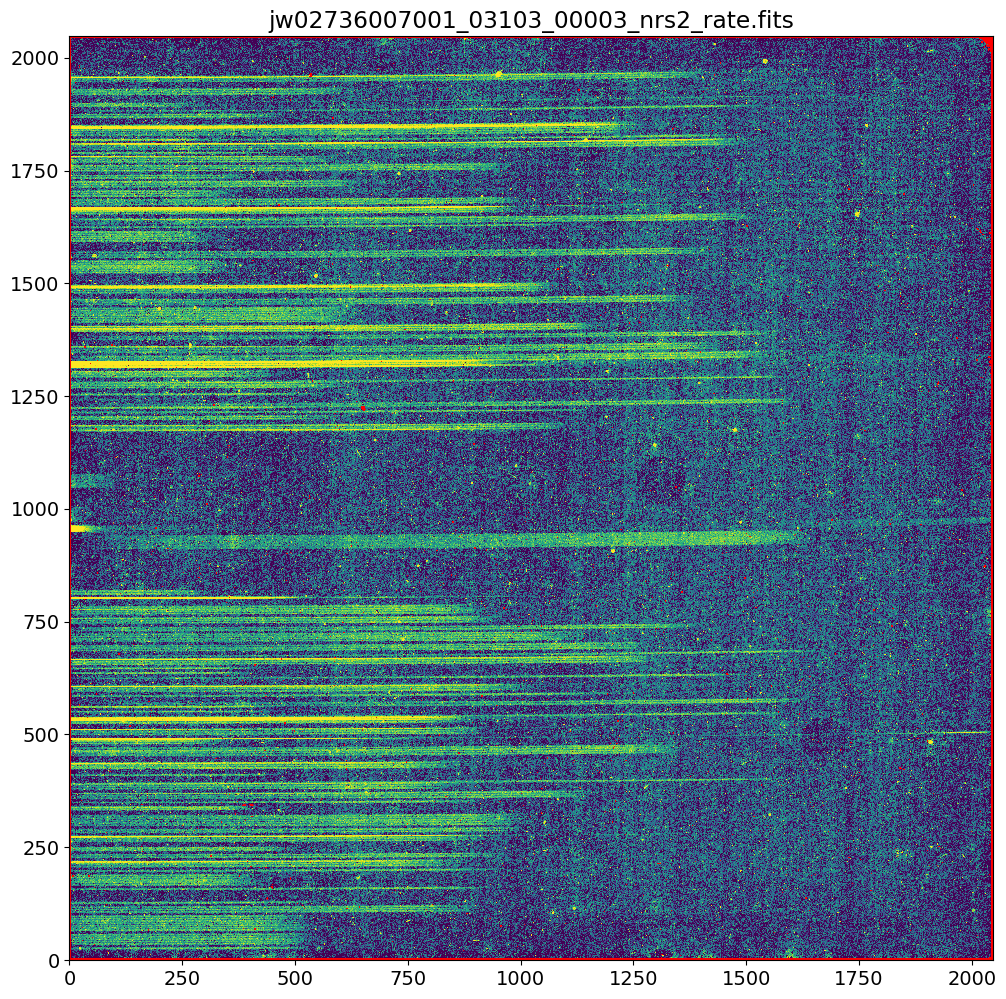

In [45]:
show_MOS_rate(rate_file)

In [ ]:
with fits.open(rate_file) as hdu_list:
    data = hdu_list['SCI'].data
    
fig, ax = plt.subplots(1, 1, figsize=(12,12))
ax.imshow(data, origin='lower', vmin=-0.01, vmax=0.02, interpolation='nearest')

## The default jump step parameters don't work as well

Compare to the data product in MAST generated using the pipeline with default parameters

2024-01-28 07:19:25,029 - stpipe - INFO - Found cached file data/jw02736007001_03103_00003_nrs2_rate.fits with expected size 83943360.


INFO: Found cached file data/jw02736007001_03103_00003_nrs2_rate.fits with expected size 83943360. [astroquery.query]
jw02736007001_03103_00003_nrs2_rate.fits


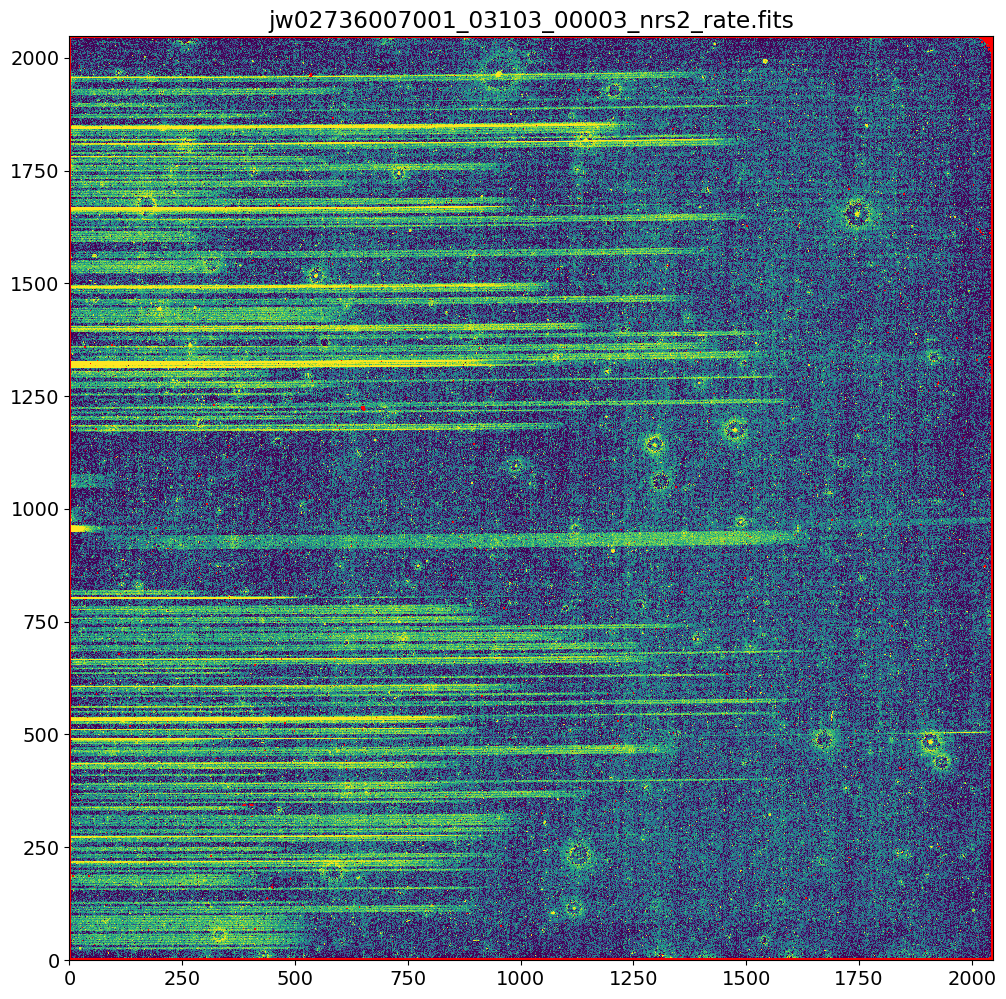

In [48]:
#download_dir = 'data'
MAST_rate_file = download_jwst_files([rate_file], download_dir)[0]
show_MOS_rate(MAST_rate_file)

# Stage 2: Spec2Pipeline: rate –> cal, s2d, x1d

https://jwst-docs.stsci.edu/jwst-science-calibration-pipeline-overview/stages-of-jwst-data-processing/calwebb_spec2

https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_spec2.html

Run on association files defining science and background slitlets for each of 3 nod exposures  
3 exposures x 2 detectors = 6 association files  

Spec2Pipeline takes 7 minutes on a MacBook Pro laptop (with reference files already downloaded)

In [146]:
# First retrieve the MSA METAFILE that defines all the shutters (slitlets) and sources
# including where they are, and which shutters have science data vs. background

hdu_list = fits.open(rate_file)
msa_metafile = hdu_list[0].header['MSAMETFL']
msa_metafile = os.path.join(output_dir, msa_metafile)
hdu_list = fits.open(msa_metafile)
hdu_list.info()

Filename: reprocess/jw02736007001_01_msa.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      16   ()      
  1  SHUTTER_IMAGE    1 ImageHDU         8   (342, 730)   int16   
  2  SHUTTER_INFO    1 BinTableHDU     33   1318R x 12C   [I, I, I, I, I, J, 1A, 6A, E, E, I, 1A]   
  3  SOURCE_INFO    1 BinTableHDU     25   119R x 8C   [J, J, 20A, 31A, D, D, 30A, D]   


In [ ]:
rate_files = glob(os.path.join(output_dir, '*_rate.fits'))

for rate_file in rate_files:
    try:
        # Download MSA metafile
        msa_file = fits.getval(rate_file, 'MSAMETFL')
        download_jwst_files([msa_file], output_dir)
    except:
        pass

Downloading URL https://mast.stsci.edu/api/v0.1/Download/file?uri=mast:jwst/product/jw02736007001_01_msa.fits to reprocess/jw02736007001_01_msa.fits ... [Done]

In [148]:
spec2pipe = Spec2Pipeline()

2024-01-28 08:25:15,288 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2024-01-28 08:25:15,290 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2024-01-28 08:25:15,293 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2024-01-28 08:25:15,294 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.
2024-01-28 08:25:15,295 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.
2024-01-28 08:25:15,296 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.
2024-01-28 08:25:15,299 - stpipe.Spec2Pipeline.master_background_mos - INFO - MasterBackgroundMosStep instance created.
2024-01-28 08:25:15,301 - stpipe.Spec2Pipeline.master_background_mos.flat_field - INFO - FlatFieldStep instance created.
2024-01-28 08:25:15,302 - stpipe.Spec2Pipeline.master_background_mos.pathloss - INFO - PathLossStep instance created.
2024-01-28 08:25:15,303 - stpipe.Spec2Pipeline.

In [72]:
spec2pipe.__dict__

{'_reference_files_used': [],
 '_log_records': [],
 '_input_filename': None,
 '_input_dir': None,
 '_keywords': {},
 'name': 'Spec2Pipeline',
 'qualified_name': 'stpipe.Spec2Pipeline',
 'parent': None,
 'pre_hooks': [],
 'post_hooks': [],
 'output_file': None,
 'output_dir': None,
 'output_ext': '.fits',
 'output_use_model': False,
 'output_use_index': True,
 'save_results': False,
 'skip': False,
 'suffix': None,
 'search_output_file': True,
 'save_bsub': False,
 'fail_on_exception': True,
 'save_wfss_esec': False,
 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': None, 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None, 'wfss_mmag_extract': None, 'override_wfssbkg': None, 'override_wavelengthrange': None, 'class': ''}, 'assign_wcs': {'pre_hooks': [

In [ ]:
# rate files need to be in same directory as association file  

In [87]:
#spec2_asn_files = glob(os.path.join(asn_dir, '*.json'))
spec2_asn_files = glob(os.path.join(output_dir, '*.json'))
spec2_asn_files = select_files(spec2_asn_files, ['o007', 'spec2'])
spec2_asn_files = sorted(spec2_asn_files)
spec2_asn_files

['reprocess/jw02736-o007_20231116t144653_spec2_00001_asn.json',
 'reprocess/jw02736-o007_20231116t144653_spec2_00002_asn.json',
 'reprocess/jw02736-o007_20231116t144653_spec2_00003_asn.json',
 'reprocess/jw02736-o007_20231116t144653_spec2_00004_asn.json',
 'reprocess/jw02736-o007_20231116t144653_spec2_00005_asn.json',
 'reprocess/jw02736-o007_20231116t144653_spec2_00006_asn.json']

In [83]:
for asn_file in spec2_asn_files:
    print('-' * 33)
    print(os.path.basename(asn_file))
    with open(asn_file, 'r') as f_obj:
        asn_file_data = json.load(f_obj)

    for member in asn_file_data['products'][0]['members']:
        print(member['expname'], member['exptype'])

---------------------------------
jw02736-o007_20231116t144653_spec2_00001_asn.json
jw02736007001_03103_00003_nrs2_rate.fits science
jw02736007001_03103_00001_nrs2_rate.fits background
jw02736007001_03103_00002_nrs2_rate.fits background
---------------------------------
jw02736-o007_20231116t144653_spec2_00002_asn.json
jw02736007001_03103_00002_nrs2_rate.fits science
jw02736007001_03103_00001_nrs2_rate.fits background
jw02736007001_03103_00003_nrs2_rate.fits background
---------------------------------
jw02736-o007_20231116t144653_spec2_00003_asn.json
jw02736007001_03103_00001_nrs2_rate.fits science
jw02736007001_03103_00002_nrs2_rate.fits background
jw02736007001_03103_00003_nrs2_rate.fits background
---------------------------------
jw02736-o007_20231116t144653_spec2_00004_asn.json
jw02736007001_03103_00003_nrs1_rate.fits science
jw02736007001_03103_00001_nrs1_rate.fits background
jw02736007001_03103_00002_nrs1_rate.fits background
---------------------------------
jw02736-o007_20231

In [158]:
spec2pipe.steps['resample_spec']['weight_type']

'ivm'

In [160]:
params_spec2 = {}

# Already the current default; could set explicitly if needed:
#params_spec2['resample_spec'] = {  
    #'weight_type': 'ivm'  # pixel-based inverse read noise (vs. 'exptime' single value exposure time)
#}

params_spec2

{}

In [ ]:
for asn_file in spec2_asn_files:
    spec2_result = Spec2Pipeline.call(
        asn_file,
        save_results = True,
        output_dir = output_dir,
        steps = params_spec2
    )

In [ ]:
# Output cleared

In [ ]:
#rate_files = glob(os.path.join(output_dir, '*_rate.fits'))
rate_files = [rate_file]

for rate_file in rate_files:
    try:
        # Download MSA metafile
        msa_file = fits.getval(rate_file, 'MSAMETFL')
        download_jwst_files([msa_file], output_dir)
    
        spec2pipe = Spec2Pipeline()
        #spec2pipe.resample_spec.weight_type = 'exptime' # better for high SNR data – see NS-MOS07 https://jwst-docs.stsci.edu/jwst-calibration-pipeline-caveats/jwst-nirspec-mos-pipeline-caveats
        #spec2pipe.pathloss.skip = True  # Skip path loss corrections
        #spec2pipe.nsclean.skip = False  # Run NSClean 1/f noise striping removal (implemented in pipeline version 1.12.6 but off by default)
        spec2pipe.save_results = True
        spec2pipe.output_dir = output_dir
        spec2_result = spec2pipe(rate_file)
    except:
        print('spec2pipe FAILED on', rate_file)

# Stage 3: Spec3Pipeline: combine multiple exposures

https://jwst-docs.stsci.edu/jwst-science-calibration-pipeline-overview/stages-of-jwst-data-processing/calwebb_spec3

https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_spec3.html

In [12]:
spec3pipe = Spec3Pipeline()

2024-01-27 07:54:36,114 - stpipe.Spec3Pipeline - INFO - Spec3Pipeline instance created.
2024-01-27 07:54:36,115 - stpipe.Spec3Pipeline.assign_mtwcs - INFO - AssignMTWcsStep instance created.
2024-01-27 07:54:36,116 - stpipe.Spec3Pipeline.master_background - INFO - MasterBackgroundStep instance created.
2024-01-27 07:54:36,117 - stpipe.Spec3Pipeline.mrs_imatch - INFO - MRSIMatchStep instance created.
2024-01-27 07:54:36,118 - stpipe.Spec3Pipeline.outlier_detection - INFO - OutlierDetectionStep instance created.
2024-01-27 07:54:36,119 - stpipe.Spec3Pipeline.resample_spec - INFO - ResampleSpecStep instance created.
2024-01-27 07:54:36,121 - stpipe.Spec3Pipeline.cube_build - INFO - CubeBuildStep instance created.
2024-01-27 07:54:36,123 - stpipe.Spec3Pipeline.extract_1d - INFO - Extract1dStep instance created.
2024-01-27 07:54:36,124 - stpipe.Spec3Pipeline.photom - INFO - PhotomStep instance created.
2024-01-27 07:54:36,124 - stpipe.Spec3Pipeline.combine_1d - INFO - Combine1dStep instance

In [39]:
spec3pipe.__dict__.keys()

dict_keys(['_reference_files_used', '_log_records', '_input_filename', '_input_dir', '_keywords', 'name', 'qualified_name', 'parent', 'pre_hooks', 'post_hooks', 'output_file', 'output_dir', 'output_ext', 'output_use_model', 'output_use_index', 'save_results', 'skip', 'suffix', 'search_output_file', 'steps', 'log', 'config_file', '_pre_hooks', '_post_hooks', 'assign_mtwcs', 'master_background', 'mrs_imatch', 'outlier_detection', 'resample_spec', 'cube_build', 'extract_1d', 'photom', 'combine_1d'])

In [21]:
spec3pipe.__dict__

{'_reference_files_used': [],
 '_log_records': [],
 '_input_filename': None,
 '_input_dir': None,
 '_keywords': {},
 'name': 'Spec3Pipeline',
 'qualified_name': 'stpipe.Spec3Pipeline',
 'parent': None,
 'pre_hooks': [],
 'post_hooks': [],
 'output_file': None,
 'output_dir': None,
 'output_ext': '.fits',
 'output_use_model': False,
 'output_use_index': True,
 'save_results': False,
 'skip': False,
 'suffix': None,
 'search_output_file': True,
 'steps': {'assign_mtwcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'assign_mtwcs', 'search_output_file': True, 'input_dir': None, 'class': ''}, 'master_background': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': 

In [ ]:
# Alternatively, you could extract that info from the data products
#spec3_cal_asn_file = cal_model[0].meta.asn.table_name
#spec2_cal_asn_file = cal_model.exposures[0].meta.asn.table_name

In [53]:
asn_files = glob(os.path.join(output_dir, '*.json'))
spec3_asn_file = select_files(asn_files, ['o007', 'spec3'])  # Observation 7 (Observation 8 is similar; could do separately)
spec3_asn_file

'reprocess/jw02736-o007_20231116t144653_spec3_00001_asn.json'

In [111]:
with open(spec3_asn_file) as f_obj:
    asn_data = json.load(f_obj)
    spec2_cal_files = []
    for member in asn_data['products'][0]['members']:
        if member['exptype'] == 'science':
            spec2_cal_file = member['expname']
            spec2_cal_files.append(spec2_cal_file)
            print(spec2_cal_file)

jw02736007001_03103_00001_nrs1_cal.fits
jw02736007001_03103_00001_nrs2_cal.fits
jw02736007001_03103_00002_nrs1_cal.fits
jw02736007001_03103_00002_nrs2_cal.fits
jw02736007001_03103_00003_nrs1_cal.fits
jw02736007001_03103_00003_nrs2_cal.fits


In [ ]:
#asn_data

In [112]:
# Create a subdirectory for the many output files (several for each extracted source)
spec3_output_dir = os.path.join(output_dir, 'spec3')
os.makedirs(spec3_output_dir, exist_ok=True)
spec3_output_dir

'reprocess/spec3'

In [113]:
params_spec3 = {}
params_spec3['outlier_detection'] = {'skip' : False} # Flag outlier bad pixels and cosmic rays in DQ array of each input image
params_spec3['resample_spec']     = {'weight_type' : 'ivm'}  # pixel-based inverse read noise (vs. 'exptime' single value exposure time)
params_spec3['extract_1d']        = {'use_source_posn' : 'True'} # extraction rows based on expected source position
params_spec3

{'outlier_detection': {'skip': False},
 'resample_spec': {'weight_type': 'ivm'},
 'extract_1d': {'use_source_posn': 'True'}}

In [54]:
spec3_asn_file

'reprocess/jw02736-o007_20231116t144653_spec3_00001_asn.json'

In [ ]:
spec3_result = Spec3Pipeline.call(
    spec3_asn_file,
    save_results = True,
    output_dir = spec3_output_dir,
    steps = params_spec3
)

In [ ]:
# Output cleared

In [ ]:
# run the calwebb_spec3 pipeline using the association file as input
if 0:
    spec3pipe = Spec3Pipeline()
    spec3.save_results = True
    spec3.output_dir = spec3_output_dir
    spec3_result = spec3pipe(spec3_asn_file)

# Show spectrum result

In [108]:
#def show_MOS_spectrum(s2d_model, x1d_model, source_id=None, cmap='viridis', bad_color=(1,0.7,0.7), min_percent=2, max_percent=99.9, ymin=-2e-6, ymax=1e-5):
def show_MOS_spectrum(s2d_model, x1d_model, source_id=None, cmap='RdBu', bad_color='w',
                     ystart=None, ystop=None): #, bad_color=(0.88,0.88,0.88)):
    # 2D spectrum
    #if source_id:  # s2d has all the objects; extract the one with source_id
    if 'slits' in list(s2d_model):  # s2d has all the objects; extract the one with source_id
        source_ids = [slit.source_id for slit in s2d_model.slits]
        i_slit = source_ids.index(source_id)
        slit_model = s2d_model.slits[i_slit]
    else:  # s2d only has one object
        slit_model = s2d_model
        i_slit = 0
        
    s2d_data = slit_model.data + 0  # load and make copy
    s2d_data = np.where(slit_model.err, s2d_data, np.nan)  # Replace zeros with nan where there is no data

    # 1D spectrum
    x1d_wave    = x1d_model.spec[i_slit].spec_table.WAVELENGTH
    x1d_flux    = x1d_model.spec[i_slit].spec_table.FLUX
    x1d_fluxerr = x1d_model.spec[i_slit].spec_table.FLUX_ERROR
    if np.sum(np.isnan(x1d_fluxerr)) == len(x1d_fluxerr):  # fluxerr all nan?? pipeline bug
        x1d_flux = np.where(x1d_flux, x1d_flux, np.nan)  # Replace zeros with nan where there is no data
    else:
        x1d_flux = np.where(np.isnan(x1d_fluxerr), np.nan, x1d_flux)  # Replace zeros with nan where there is no data
    #x1dflux = np.where(x1dfluxerr, x1dflux, np.nan)  # Replace zeros with nan where there is no data

    wave_min, wave_max = x1d_wave[0], x1d_wave[-1]
    eps = 1e-7
    #major_tick_interval = 0.5
    major_tick_interval = 0.2
    xtick_min = np.ceil((wave_min - eps) / major_tick_interval) * major_tick_interval
    xticks = np.arange(xtick_min, wave_max, major_tick_interval)
    #xticks = np.append(xticks, [5.2])
    num_waves = len(x1d_wave)
    xtick_pos = np.interp(xticks, x1d_wave, np.arange(num_waves))
    xtick_labels = ['%.1f' % xtick for xtick in xticks]
    
    #xtick_labels = [label.replace('4.8', '') for label in xtick_labels]  # remove 4.8
    # Remove any tick labels that are too close and would overlap
    for i in range(len(xtick_pos)-1):
        dx = xtick_pos[i+1] - xtick_pos[i]
        if dx < 40:
            xtick_labels[i] = ''
    
    #for label in xtick_labels: print(label, ' ', end='')

    # Make Figure
    fig, (ax2d, ax1d) = plt.subplots(2, 1, figsize=(15,8), height_ratios=[1,3], squeeze=True, sharex=True)
    cmap = matplotlib.colormaps[cmap]
    cmap.set_bad(bad_color, 1.)

    sigma_clipped_data = sigma_clip(s2d_data, sigma=5, maxiters=3)
    ymin = np.min(sigma_clipped_data)
    #ymin = 0.2 * ymin
    ymax = np.max(sigma_clipped_data)
    #ymin = -ymax  # center range about zero; but there may be some bias positive or negative

    #ymax = 2 * np.nanpercentile(s2d_data, 90)
    #ymin = -0.2 * ymax
    
    # plot the rectified 2D spectrum
    #norm = simple_norm(s2dsci, 'linear', min_percent=2, max_percent=99.9)
    #norm = simple_norm(s2d_data, 'asinh', min_percent=min_percent, max_percent=max_percent)
    norm = simple_norm(s2d_data, 'linear', min_cut=ymin, max_cut=ymax)
    print('s2d range:', norm.vmin, norm.vmax)
    im = ax2d.imshow(s2d_data, origin='lower', cmap=cmap, aspect='auto', norm=norm, interpolation='nearest')
    num_cross, num_dispersion = s2d_data.shape
    width_1d = 3
    ny, nx = s2d_data.shape
    ax2d.yaxis.set_ticks_position('both')
    #ax2d.axhline((ny-1)/2., c='w', lw=0.5, alpha=0.5, ls='--')
    if ystart:
        for y in ystart, ystop:
            #ax2d.axhline(y, c='w', lw=0.5, alpha=0.5, ls='--')
            ax2d.axhline(y, c='m', lw=0.5)
        ax2d.set_yticks([0, ystart, ystop, ny-1])
        if 1:
            extract_width = 8
            ystart0 = ny/2 - extract_width/2
            ystop0  = ny/2 + extract_width/2
            for y in ystart0, ystop0:
                ax2d.axhline(y, c='0.50', lw=0.5, ls='--', dashes=(10,10))
    else:
        ax2d.set_yticks([0, (ny-1)/2., ny-1])
    
    # plot the 1D extraction  x1d vs. indices, same as s2d array above
    ax1d.axhline(0, c='0.50', lw=0.5, alpha=0.66, ls='-')
    ax1d.step(np.arange(num_waves), x1d_fluxerr, lw=0.5, c='r', alpha=0.66)
    ax1d.step(np.arange(num_waves), x1d_flux, lw=1)
    ax1d.set_xlim(0, num_waves)
    ax1d.yaxis.set_ticks_position('both')

    #ax1d.set_ylim(-2e-6, 2e-5)
    #ax1d.set_ylim(ymin, ymax)
    
    title = 'S2D  ' + os.path.basename(s2d_model.meta.filename) 
    title += '  slit %d'   % slit_model.slitlet_id
    title += '  source %d' % slit_model.source_id
    ax2d.set_title(title)
    plt.xticks(xtick_pos, xtick_labels)
    plt.xlabel('wavelength (microns)');

In [105]:
source_id = 6355
s2d_file = 'jw02736-o007_s%05d_nirspec_f290lp-g395m_s2d.fits' % source_id
#spec3_output_dir = os.path.join(output_dir, 'spec3')
s2d_file = os.path.join(spec3_output_dir, s2d_file)
print(s2d_file)
s2d_model = datamodels.open(s2d_file)
#s2d_data = s2d_model.data + 0

reprocess/spec3/jw02736-o007_s06355_nirspec_f290lp-g395m_s2d.fits


In [106]:
x1d_file = s2d_file.replace('s2d', 'x1d')
print(x1d_file)
x1d_model = datamodels.open(x1d_file)

reprocess/spec3/jw02736-o007_s06355_nirspec_f290lp-g395m_x1d.fits


2024-01-28 07:54:28,978 - stpipe - WARNING - Input data contains invalid values (NaNs or infs), which were automatically clipped.


s2d range: -0.7664494514465332 0.7519416213035583


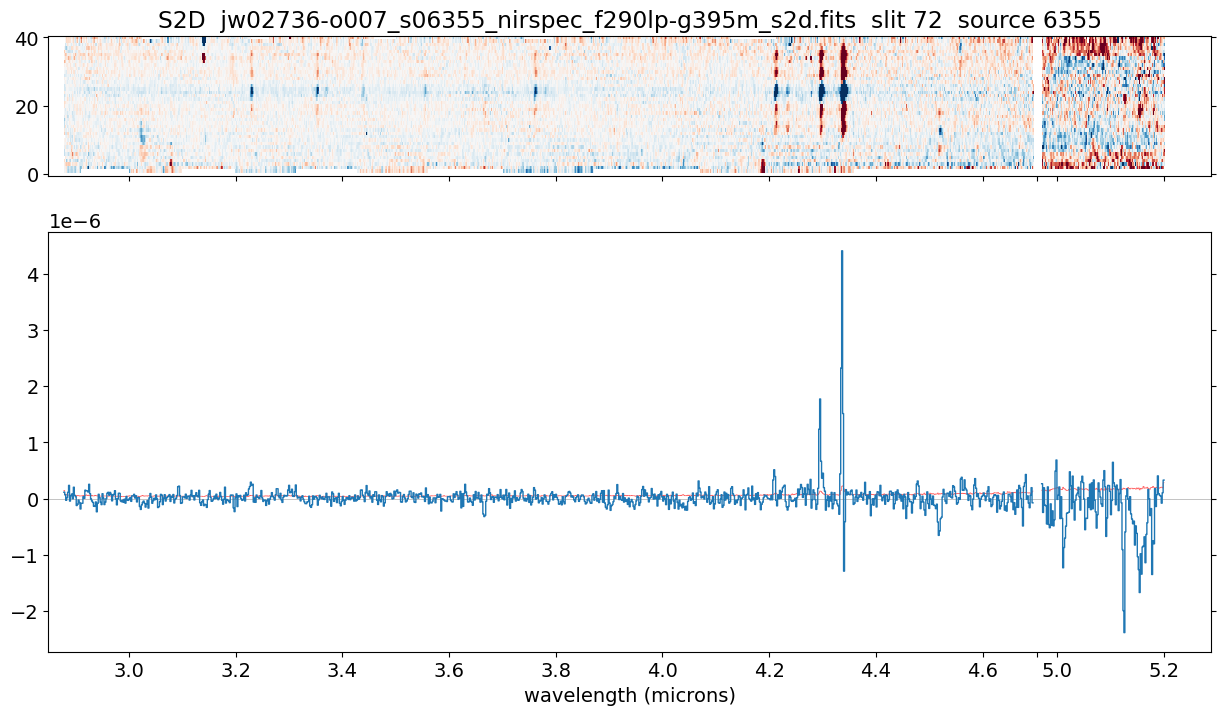

In [107]:
show_MOS_spectrum(s2d_model, x1d_model, source_id)

# Adjust 2D –> 1D extraction: extract1d

https://jwst-pipeline.readthedocs.io/en/latest/jwst/extract_1d

https://jwst-pipeline.readthedocs.io/en/latest/api/jwst.extract_1d.Extract1dStep.html

https://jwst-pipeline.readthedocs.io/en/latest/jwst/extract_1d/description.html#extraction-for-2d-slit-data

Which rows in S2D should be used for extraction to X1D? Define extraction region in `.json` file, then run `Extract1dStep`  
Output file will end in `_extract1dstep.fits`

`extract_width` takes priority over `ystart` and `ystop` for the extraction width,   
but `ystart` and `ystop` will still be used to define the centering of the extraction region in the cross-dispersion direction.

All of these values are zero-indexed integers. The start and stop limits are inclusive.

https://jwst-pipeline.readthedocs.io/en/latest/jwst/extract_1d/reference_files.html#editing-json-reference-file-format-for-non-ifu-data

The default EXTRACT1D reference file is found in CRDS. The user can download this file from https://jwst-crds.stsci.edu, modify the contents, and then use this modified file in `Extract1dStep` by specifying this modified reference file with the `override_extract1d` option


### See also

* Adjusting the extraction region:
https://github.com/spacetelescope/jwst-caveat-examples/blob/main/NIRSPEC_General/nrs_recenter_extraction_workaround.ipynb
* MOSViz interactive extraction: 
https://spacetelescope.github.io/jdat_notebooks/notebooks/mos_spectroscopy_advanced/MOSspec_advanced.html
* Optimal extraction:
https://spacetelescope.github.io/jdat_notebooks/notebooks/optimal_extraction/Spectral_Extraction-static.html
* msaexp optimal extraction:
https://github.com/gbrammer/msaexp/blob/d7368560cf465a0828e942454cfcc0bbe6870278/msaexp/drizzle.py#L869C19-L869C19


### Either download the default extract1d parameter file from https://jwst-crds.stsci.edu ...

(there should be some way to automate this: find and download the latest reference file)

In [132]:
default_extract1d_json_file = 'jwst_nirspec_extract1d_0003.json'

In [133]:
with open(default_extract1d_json_file) as f_obj:
    extract1d_json_data = json.load(f_obj)

In [135]:
#extract1d_json_data
JSON(extract1d_json_data, expanded=True)

<IPython.core.display.JSON object>

### ...or create the JSON file from scratch

In [130]:
extract1d_json_data = {'reftype':'EXTRACT1D', 'instrument':'NIRSPEC', 'telescope':'JWST', 'exp_type':'NRS_MSASPEC'}
extract1d_json_data['apertures'] = [{'id':'ANY', 'region_type':'target', 'independent_var':'pixel', 'bkg_order':0, 'dispaxis':1,
                                   'extract_width':8,  # Best not to adjust this. Slit losses are calibrated to this extraction width.
                                   }]

json_object = json.dumps(extract1d_json_data, indent=4)
default_extract1d_json_file = 'jwst_nirspec_extract1d_default.json'
with open(default_extract1d_json_file, "w") as outfile:
    outfile.write(json_object)

JSON(extract1d_json_data, expanded=True)

<IPython.core.display.JSON object>

### Define the extraction region

In [136]:
#ystart = 21  # You decide which rows to use for the extraction region
ycenter = 25
extract_width = extract1d_json_data['apertures'][0]['extract_width']  # use default extraction width
ystart = ycenter - extract_width // 2
ystop = ystart + extract_width - 1
extract1d_json_data['apertures'][0]['ystart'] = ystart
extract1d_json_data['apertures'][0]['ystop']  = ystop
print(ystart, ystop)

21 28


In [137]:
extract1d_json_data['apertures'][0]

{'id': 'ANY',
 'region_type': 'target',
 'independent_var': 'pixel',
 'bkg_order': 0,
 'extract_width': 8,
 'dispaxis': 1,
 'ystart': 21,
 'ystop': 28}

In [138]:
json_object = json.dumps(extract1d_json_data, indent=4)
custom_extract1d_json_file = 'jwst_nirspec_extract1d_custom.json'
with open(custom_extract1d_json_file, "w") as outfile:
    outfile.write(json_object)

In [139]:
extract1d_result = Extract1dStep.call(s2d_file,
                            use_source_posn=False, 
                            apply_apcorr=False,
                            override_extract1d = custom_extract1d_json_file,
                            save_results=True, output_dir=spec3_output_dir)

# Output file ends in _extract1dstep (not _x1d); okay to save in same output directory
# jw02736-o007_s06355_nirspec_f290lp-g395m_extract1dstep.fits

2024-01-28 08:15:34,764 - stpipe.Extract1dStep - INFO - Extract1dStep instance created.
2024-01-28 08:15:35,005 - stpipe.Extract1dStep - INFO - Step Extract1dStep running with args ('reprocess/spec3/jw02736-o007_s06355_nirspec_f290lp-g395m_s2d.fits',).
2024-01-28 08:15:35,007 - stpipe.Extract1dStep - INFO - Step Extract1dStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': 'reprocess/spec3', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'smoothing_length': None, 'bkg_fit': None, 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': False, 'center_xy': None, 'apply_apcorr': False, 'ifu_autocen': False, 'ifu_rfcorr': False, 'ifu_set_srctype': None, 'ifu_rscale': None, 'soss_atoca': True, 'soss_threshold': 0.01, 'soss_n_os': 2, 'soss_wave_grid_in': None, 'soss_wave_gri

### Show the result

2024-01-28 08:15:38,472 - stpipe - WARNING - Input data contains invalid values (NaNs or infs), which were automatically clipped.


s2d range: -0.7664494514465332 0.7519416213035583


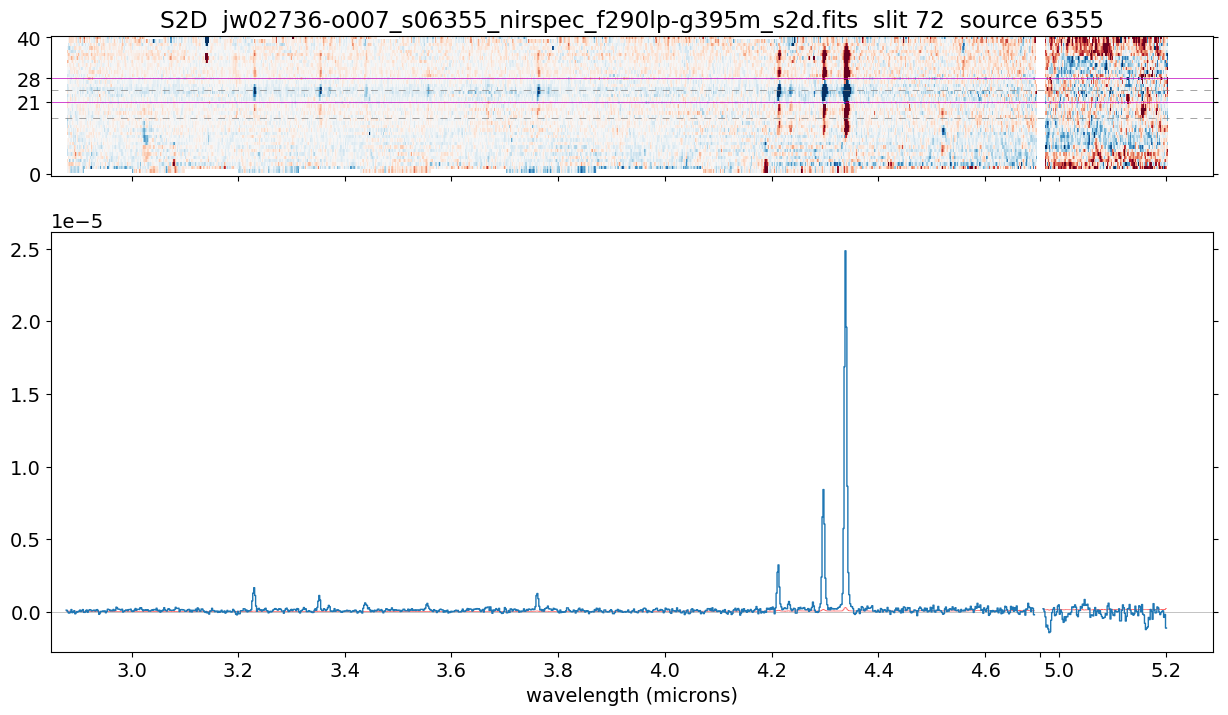

In [140]:
#show_MOS_spectrum(s2d_model, x1d_model, source_id)
show_MOS_spectrum(s2d_model, extract1d_result, ystart=ystart, ystop=ystop)

### Compare to spectrum in MAST from default pipeline extraction

In [102]:
s2d_file

'reprocess/spec3/jw02736-o007_s06355_nirspec_f290lp-g395m_s2d.fits'

In [96]:
x1d_file = s2d_file.replace('s2d', 'x1d')
s2d_model = datamodels.open(s2d_file)
x1d_model = datamodels.open(x1d_file)
x1d_wave = x1d_model.spec[0].spec_table.WAVELENGTH
x1d_flux = x1d_model.spec[0].spec_table.FLUX

In [87]:
MAST_s2d_file = download_jwst_files([s2d_file], download_dir)[0]
MAST_s2d_model = datamodels.open(MAST_s2d_file)

In [88]:
x1d_file = s2d_file.replace('s2d', 'x1d')
MAST_x1d_file = download_jwst_files([x1d_file], download_dir)[0]
MAST_x1d_model = datamodels.open(MAST_x1d_file)

In [89]:
x1d_wave_MAST = MAST_x1d_model.spec[0].spec_table.WAVELENGTH
x1d_flux_MAST = MAST_x1d_model.spec[0].spec_table.FLUX

In [99]:
num_waves = len(x1d_wave)
wave_min, wave_max = x1d_wave[0], x1d_wave[-1]
eps = 1e-7
#major_tick_interval = 0.5
major_tick_interval = 0.2
xtick_min = np.ceil((wave_min - eps) / major_tick_interval) * major_tick_interval
xticks = np.arange(xtick_min, wave_max, major_tick_interval)
#xticks = np.append(xticks, [5.2])
num_waves = len(x1d_wave)
xtick_pos = np.interp(xticks, x1d_wave, np.arange(num_waves))
xtick_labels = ['%.1f' % xtick for xtick in xticks]

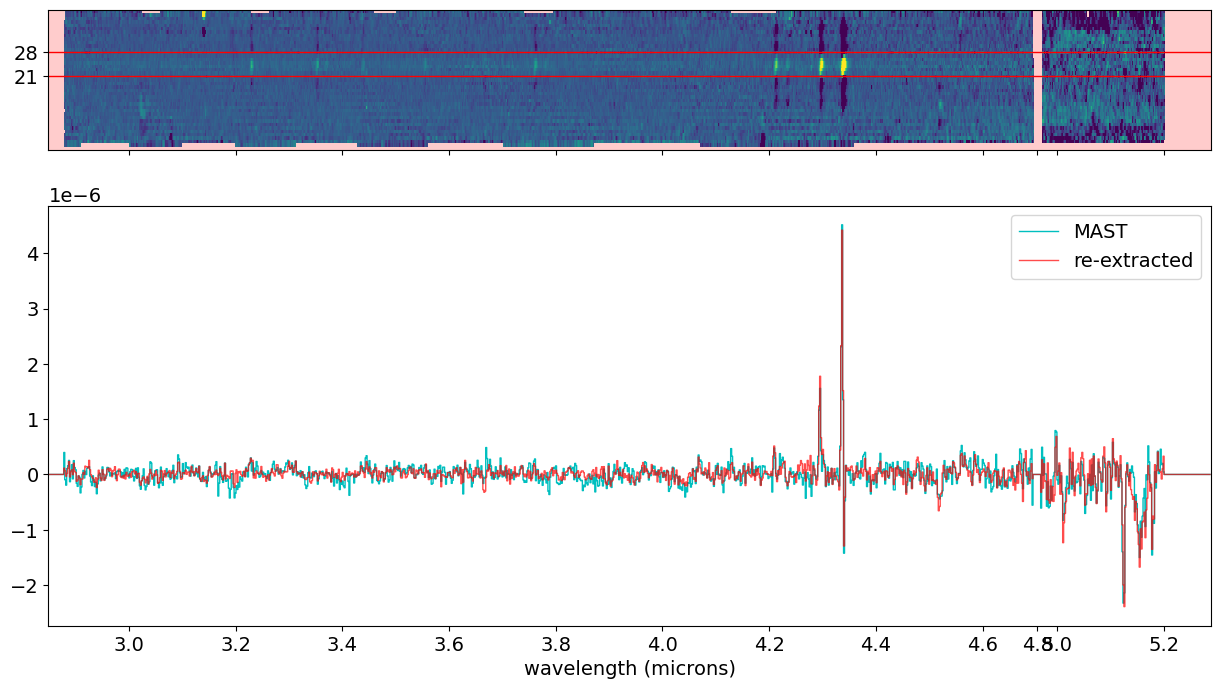

In [141]:
fig, (ax2d, ax1d) = plt.subplots(2, 1, figsize=(15,8), height_ratios=[1,3], squeeze=True, sharex=True)

# plot the rectified 2D spectrum
#norm = simple_norm(s2dsci, 'linear', min_percent=10, max_percent=99.9)
s2d_data = np.where(s2d_model.err, s2d_model.data, np.nan)  # Replace zeros with nan where there is no data
norm = simple_norm(s2d_data, 'asinh', min_percent=2, max_percent=99.95)
cmap = matplotlib.colormaps['viridis']
cmap.set_bad((1,0.8,0.8), 1.)
im = ax2d.imshow(s2d_data, origin='lower', cmap=cmap, aspect='auto', norm=norm, interpolation='nearest')

ax1d.step(np.arange(num_waves), x1d_flux_MAST, lw=1, c='c', label='MAST')
ax1d.step(np.arange(num_waves), x1d_flux,      lw=1, c='r', label='re-extracted', alpha=0.7)
#xlim = ax1d.get_xlim()
ax1d.set_xlim(0, num_waves)
ax2d.set_yticks([ystart, ystop])
for y in ystart, ystop:
    ax2d.axhline(y, c='r', alpha=1, lw=1, ls='-')

plt.xticks(xtick_pos, xtick_labels)
plt.xlabel('wavelength (microns)')
plt.legend();